Проект Кредитный скоринг.

Целью этой работы является анализ данных о выдаче кредитов и построение оптимальной модели классического машинного обучения для предсказания бинарного признака (стоит выдавать кредит человеку или нет).

Содержание:

1) Разведочный анализ данных

2) Обработка пространства признаков

3) Выбор ключевой метрики качества моделей

4) Обучение моделей, подбор гиперпараметров

5) Сравнение моделей


Подключаем необходимые библиотеки:

In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

!pip install optuna
import optuna

Считываем датасет

In [570]:
df = pd.read_csv('german_credit_cleaned.csv')

In [571]:
df.head()

,checking_acc_status,duration,cred_hist,purpose,loan_amt,saving_acc_bonds,present_employment_since,installment_rate,personal_stat_gender,other_debtors_guarantors,...,property,age,other_installment_plans,housing,num_curr_loans,job,num_people_provide_maint,telephone,is_foreign_worker,target
0,below_0,6,risky_acc_or_curr_loan_other,radio_tv,1169,unknown_no_saving_acc,above_7y,4,male:single,none,...,real_estate,67,none,own,2,skilled_official,1,yes,yes,good
1,below_200,48,curr_loans_paid_duly,radio_tv,5951,below_100,below_4y,2,female:divorced_or_married,none,...,real_estate,22,none,own,1,skilled_official,1,no,yes,bad
2,no_cheking_acc,12,risky_acc_or_curr_loan_other,education,2096,below_100,below_7y,2,male:single,none,...,real_estate,49,none,own,1,unskilled_resident,2,no,yes,good
3,below_0,42,curr_loans_paid_duly,furniture_equipment,7882,below_100,below_7y,2,male:single,guarantor,...,life_insurance_or_aggreements,45,none,for_free,1,skilled_official,2,no,yes,good
4,below_0,24,delay_in_past,car_new,4870,below_100,below_4y,3,male:single,none,...,unknown_or_no_property,53,none,for_free,2,skilled_official,2,no,yes,bad


Посмотрим на характеристики признаков и что они означают:

In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_acc_status       1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   cred_hist                 1000 non-null   object
 3   purpose                   1000 non-null   object
 4   loan_amt                  1000 non-null   int64 
 5   saving_acc_bonds          1000 non-null   object
 6   present_employment_since  1000 non-null   object
 7   installment_rate          1000 non-null   int64 
 8   personal_stat_gender      1000 non-null   object
 9   other_debtors_guarantors  1000 non-null   object
 10  present_residence_since   1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other_installment_plans   1000 non-null   object
 14  housing                  

1 checking_acc_status: Статус текущего банковского счета заемщика (например, положительный или отрицательный баланс).

2 duration: Продолжительность кредита в месяцах.

3 cred_hist: Кредитная история заемщика.

4 purpose: Цель кредита (например, покупка автомобиля, ремонт жилья и т.д.).

5 loan_amt: Сумма кредита.

6 saving_acc_bonds: Статус сбережений или облигаций заемщика.

7 present_employment_since: Стаж работы заемщика на текущем месте работы.

8 installment_rate: Процент от дохода, который заемщик должен выплачивать по кредиту.

9 personal_stat_gender: Пол заемщика.

10 other_debtors_guarantors: Наличие других заемщиков или гарантов.

11 present_residence_since: Стаж проживания по текущему адресу.

12 property: Наличие собственности (например, недвижимость).

13 age: Возраст заемщика.

14 other_installment_plans: Наличие других планов по выплате кредитов.

15 housing: Статус жилья (например, собственное жилье, аренда).

16 num_curr_loans: Количество текущих кредитов у заемщика.

17 job: Профессия заемщика.

18 num_people_provide_maint: Количество людей, которые обеспечивают финансовую поддержку заемщику.

19 telephone: Наличие телефона (например, мобильного или стационарного).

20 is_foreign_worker: Статус иностранного работника.

21 target: Целевая переменная, указывающая на то, был ли заемщик надежным (например, выполнил ли он свои обязательства по кредиту).


Посмотрим на отсутствующие значения

In [573]:
df.isna().any(axis=0)

,0
checking_acc_status,False
duration,False
cred_hist,False
purpose,False
loan_amt,False
saving_acc_bonds,False
present_employment_since,False
installment_rate,False
personal_stat_gender,False
other_debtors_guarantors,False


Мне повезло, nan-значения отсутствуют

Посмотрим на характеристики числовых признаков

In [574]:
df.describe()

,duration,loan_amt,installment_rate,present_residence_since,age,num_curr_loans,num_people_provide_maint
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Подробнее рассмотрим распределения ключевых признаков. Я посчитал именно эти признаки ключевыми, так как в будущем мы узнаем, что они вносят больший вклад для обучения алгоритмов, основанных на деревьях.

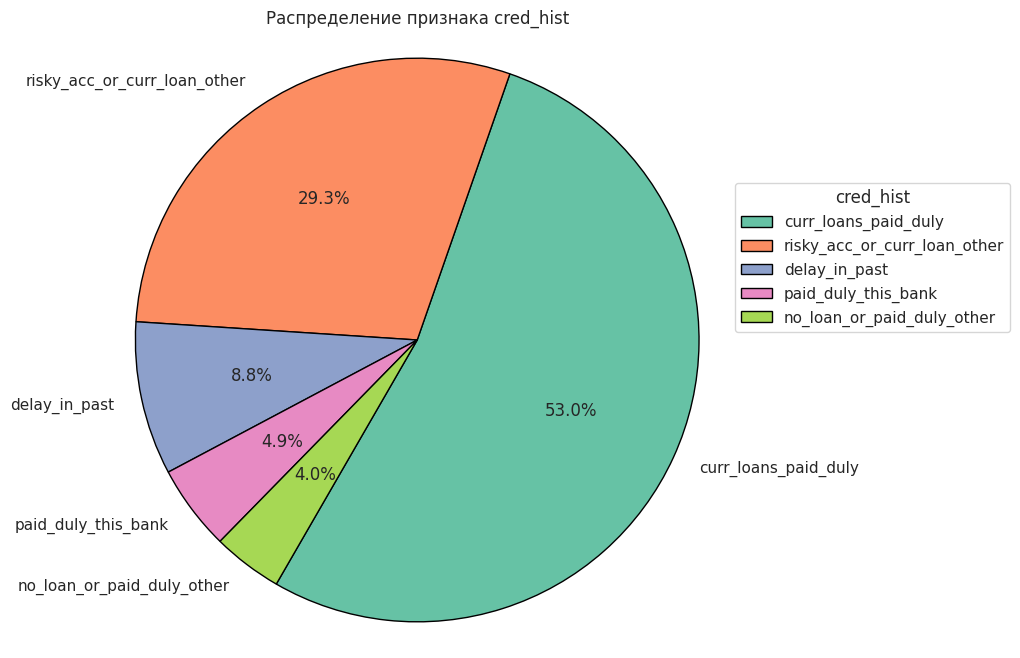

In [575]:
counts = df['cred_hist'].value_counts()
percentages = counts / counts.sum() * 100

labels = [f"{category}" for category in counts.index]

colors = sns.color_palette("Set2", len(counts))

plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=240,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)


plt.legend(labels, title='cred_hist', loc='best', bbox_to_anchor=(1, 0.5))
plt.title('Распределение признака cred_hist')
plt.axis('equal')

plt.show()


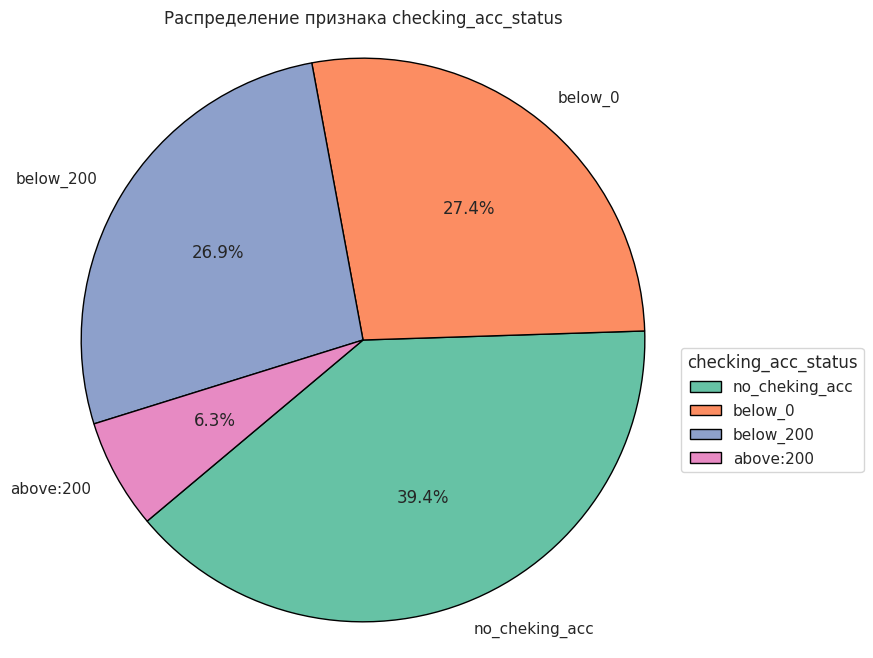

In [576]:
counts = df['checking_acc_status'].value_counts()
percentages = counts / counts.sum() * 100

labels = [f"{category}" for category in counts.index]

colors = sns.color_palette("Set2", len(counts))

plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=220,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)


plt.legend(labels, title='checking_acc_status', loc='best', bbox_to_anchor=(1, 0.5))
plt.title('Распределение признака checking_acc_status')
plt.axis('equal')
plt.show()


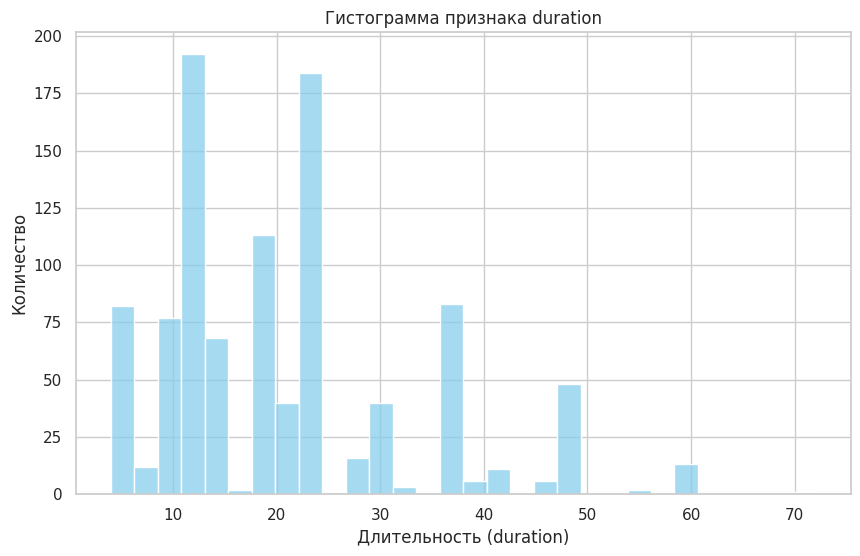

In [577]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x='duration',
    bins=30,
    kde=False,
    color='skyblue'
)


plt.xlabel('Длительность (duration)')
plt.ylabel('Количество')
plt.title('Гистограмма признака duration')
plt.show()


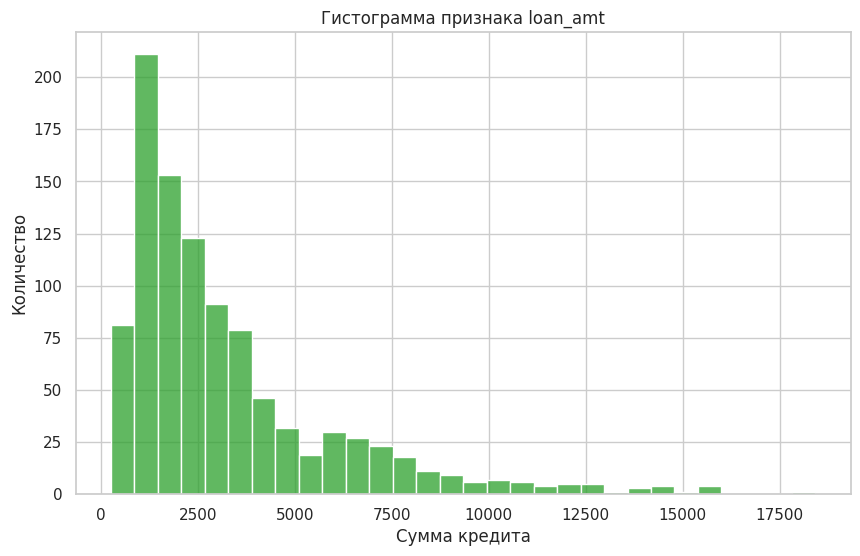

In [578]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))


sns.histplot(
    data=df,
    x='loan_amt',
    bins=30,
    kde=False,
    color='#2ca02c'
)


plt.xlabel('Сумма кредита')
plt.ylabel('Количество')
plt.title('Гистограмма признака loan_amt')
plt.show()


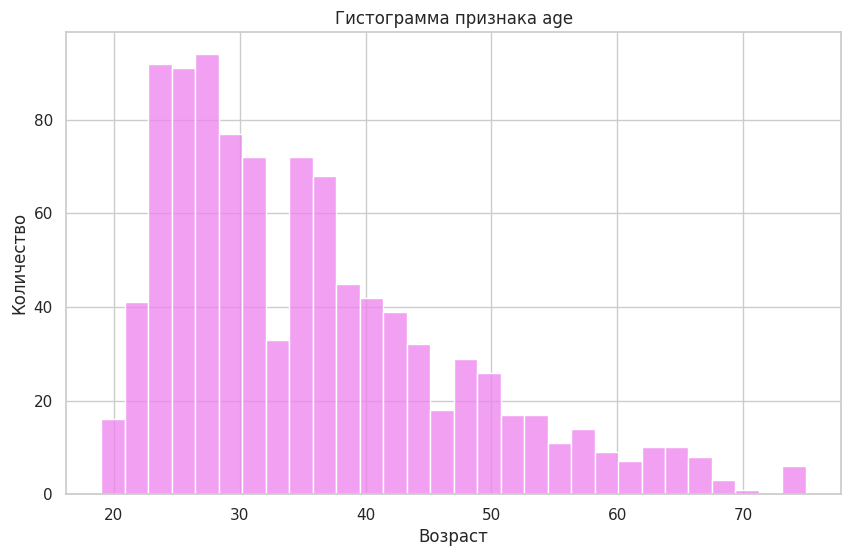

In [579]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x='age',
    bins=30,
    kde=False,
    color='violet'
)

plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Гистограмма признака age')

plt.show()


Не отвергаем гипотезу о том, что признак age имеет гамма-распределение на уровне значимости 0,05


In [580]:
data = df['age']

a, loc, scale = stats.gamma.fit(data)
stat_gamma, p_gamma = stats.kstest(data, 'gamma', args=(a, loc, scale))
print(f'{"age"} (Gamma): Statistics={stat_gamma}, p-value={p_gamma}')


age (Gamma): Statistics=0.04208071346758421, p-value=0.05629661443470768


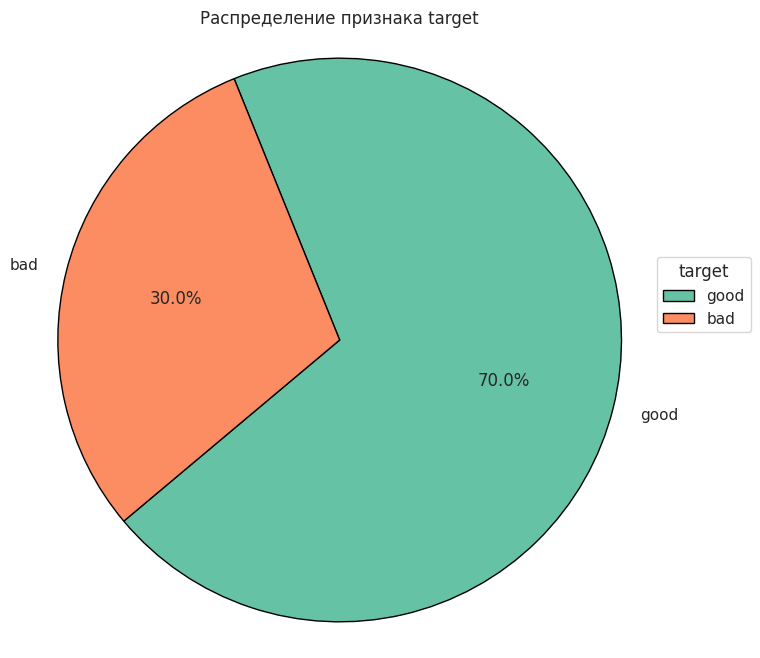

In [581]:
counts = df['target'].value_counts()
percentages = counts / counts.sum() * 100

labels = [f"{category}" for category in counts.index]

colors = sns.color_palette("Set2", len(counts))


plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=220,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)


plt.legend(labels, title='target', loc='best', bbox_to_anchor=(1, 0.5))
plt.title('Распределение признака target')
plt.axis('equal')

plt.show()


Заметим, что в целевой переменной классы не сбалансированы. Тогда в качестве ключевой метрики, которую мы будем максимизировать, будем использовать не accuracy, а roc-auc, так как roc-auc лучше подходит в случае дисбаланса классов.



Узнаем количество уникальных значений в каждом столбце:

In [582]:
unique_counts = df.nunique()

print(unique_counts)

checking_acc_status           4
duration                     33
cred_hist                     5
purpose                      10
loan_amt                    921
saving_acc_bonds              5
present_employment_since      5
installment_rate              4
personal_stat_gender          4
other_debtors_guarantors      3
present_residence_since       4
property                      4
age                          53
other_installment_plans       3
housing                       3
num_curr_loans                4
job                           4
num_people_provide_maint      2
telephone                     2
is_foreign_worker             2
target                        2
dtype: int64


Начнем преобразовывать категориальные признакии типа object в числовые.
В моем датасете существуют бинарные признаки, преобразуем их в числовой тип со значениями 0 и 1.
Также есть признаки, в значениях которых присутствует логический порядок. Если в таком признаке k уникальных значений, преобразуем их в 0, 1, ... , k-1.

In [583]:
binary_columns = ['telephone','is_foreign_worker','target']

for column in binary_columns:
    df[column], unique = pd.factorize(df[column])


orders = {
    'checking_acc_status': ['no_cheking_acc', 'below_0', 'below_200', 'above:200'],
    'cred_hist': ['delay_in_past', 'risky_acc_or_curr_loan_other', 'curr_loans_paid_duly', 'paid_duly_this_bank', 'no_loan_or_paid_duly_other'],
    'saving_acc_bonds': ['unknown_no_saving_acc', 'below_100', 'below_500', 'below_1000', 'above_1000'],
    'present_employment_since': ['unemployed',  'below_1y', 'below_4y', 'below_7y', 'above_7y'],
    'job': ['unemployed_non_resident', 'unskilled_resident', 'skilled_official', 'management_or_self_emp']
}

for column, order in orders.items():
    encoding_dict = {value: idx for idx, value in enumerate(order)}
    df[column] = df[column].map(encoding_dict)

Для остальных признаков типа object используем One Hot Encoder.

In [584]:
object_columns = df.select_dtypes(include=['object'])

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(object_columns)

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(object_columns.columns))

result_df = pd.concat([df.drop(columns=object_columns.columns), encoded_df], axis=1)



Все признаки преобразованы в числовой тип:

In [585]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   checking_acc_status                              1000 non-null   int64  
 1   duration                                         1000 non-null   int64  
 2   cred_hist                                        1000 non-null   int64  
 3   loan_amt                                         1000 non-null   int64  
 4   saving_acc_bonds                                 1000 non-null   int64  
 5   present_employment_since                         1000 non-null   int64  
 6   installment_rate                                 1000 non-null   int64  
 7   present_residence_since                          1000 non-null   int64  
 8   age                                              1000 non-null   int64  
 9   num_curr_loans                 

Разделим данные на обучающую и тестовую выборку:

In [586]:
scaler = StandardScaler()

target_column = result_df.pop('target')
result_df['target'] = target_column

feature_matrix  = scaler.fit_transform(result_df[result_df.columns[:-1]].values)

labels = result_df[result_df.columns[-1]].values


train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42, stratify=labels)


Для KNN, логистической регрессии и SVM применим метод главных компонент.

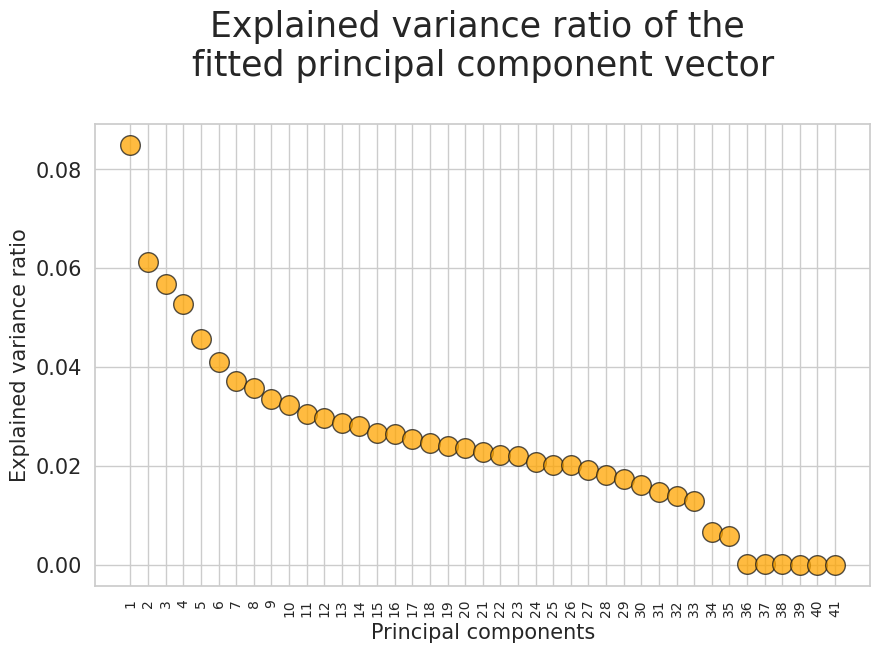

In [587]:
scaler = StandardScaler()

X = scaler.fit_transform(result_df[result_df.columns[:-1]].values)

dfx = pd.DataFrame(data=X, columns=result_df.columns[:-1])

pca = PCA(n_components=None)
dfx_pca = pca.fit(dfx)

plt.figure(figsize=(10, 6))
plt.scatter(x=[i + 1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
            s=200, alpha=0.75, c='orange', edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n", fontsize=25)
plt.xlabel("Principal components", fontsize=15)

plt.xticks([i + 1 for i in range(len(dfx_pca.explained_variance_ratio_))],
           fontsize=10, rotation=90)

plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio", fontsize=15)
plt.show()


Вручную можно проверить, что оставить 33 признака с наибольшей дисперсией будет оптмально в нашем случае.

In [588]:
pca = PCA(n_components=33)
dfx_pca = pca.fit_transform(dfx)

feature_matrix_pca = dfx_pca

train_feature_matrix_pca, test_feature_matrix_pca, train_labels_pca, test_labels_pca = train_test_split(feature_matrix_pca, labels, test_size=0.2, random_state=42, stratify=labels)

Подбор гиперпараметров в моделях KNN, логистическая регрессия и SVM происходит с помощью GridSearchCV и ручного перебора.

Обучение KNN:

In [589]:
knn = KNeighborsClassifier()

params = {
    'n_neighbors': np.arange(1, 20),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance'],
}

knn_grid = GridSearchCV(knn, params, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(train_feature_matrix_pca, train_labels_pca)

optimal_knn = knn_grid.best_estimator_

knn_grid.best_params_


{'metric': 'manhattan', 'n_neighbors': np.int64(19), 'weights': 'distance'}

In [590]:
predictions_knn = optimal_knn.predict_proba(test_feature_matrix_pca)
auc_roc = roc_auc_score(test_labels_pca, predictions_knn[:, 1])

print(f'ROC-AUC: {auc_roc:.2f}')


ROC-AUC: 0.74


Обучение логистической регрессиии:

In [591]:
lr = LogisticRegression(solver='saga',max_iter=2000,  class_weight='balanced')

params = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2']
}

lr_grid = GridSearchCV(lr, params, n_jobs=-1, cv=5, refit=True, scoring='roc_auc')

lr_grid.fit(train_feature_matrix_pca, train_labels_pca)

optimal_lr = lr_grid.best_estimator_

lr_grid.best_params_



{'C': np.int64(1), 'penalty': 'l1'}

In [592]:
predictions_lr = optimal_lr.predict_proba(test_feature_matrix_pca)
auc_roc = roc_auc_score(test_labels_pca, predictions_lr[:, 1])


print(f'ROC-AUC: {auc_roc:.2f}')

ROC-AUC: 0.76


Обучение SVM:

In [593]:
svm = SVC(probability=True, class_weight='balanced')


params = {
    'C': np.arange(1, 5),
    'kernel': [ 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(svm, params, n_jobs=-1, cv=5, refit=True, scoring='roc_auc')

svm_grid.fit(train_feature_matrix_pca, train_labels_pca)

optimal_svm = svm_grid.best_estimator_

svm_grid.best_params_


{'C': np.int64(1), 'gamma': 'scale', 'kernel': 'rbf'}

In [594]:
predictions_svm = optimal_svm.predict_proba(test_feature_matrix_pca)
auc_roc = roc_auc_score(test_labels_pca, predictions_svm[:, 1])

print(f'ROC-AUC: {auc_roc:.2f}')

ROC-AUC: 0.77


Подбор гиперпараметров дерева, случайного леса и градиентного бустинга будет происходить с помощью метода optuna.

Дерево:

In [596]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.02)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.03)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    tree.fit(train_feature_matrix, train_labels)

    predictions_tree = tree.predict_proba(test_feature_matrix)

    auc_roc = roc_auc_score(test_labels, predictions_tree[:, 1])

    return auc_roc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params = study.best_params
tree = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=42
)

tree.fit(train_feature_matrix, train_labels)

def summarize_study(study):
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  ROC-AUC: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

summarize_study(study)


[I 2025-05-25 17:02:33,682] A new study created in memory with name: no-name-9dfbbbed-2295-49e0-858b-a6d8eb5f9342
[I 2025-05-25 17:02:33,695] Trial 0 finished with value: 0.7826785714285716 and parameters: {'max_depth': 14, 'min_samples_split': 0.012497538339770211, 'min_samples_leaf': 0.01873685470115677, 'criterion': 'gini'}. Best is trial 0 with value: 0.7826785714285716.
[I 2025-05-25 17:02:33,710] Trial 1 finished with value: 0.8019642857142857 and parameters: {'max_depth': 18, 'min_samples_split': 0.01619659437604461, 'min_samples_leaf': 0.018946905542675745, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8019642857142857.
[I 2025-05-25 17:02:33,721] Trial 2 finished with value: 0.6969642857142858 and parameters: {'max_depth': 17, 'min_samples_split': 0.011251197732080831, 'min_samples_leaf': 0.011507934124910649, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8019642857142857.
[I 2025-05-25 17:02:33,730] Trial 3 finished with value: 0.7147619047619048 and paramet

Number of finished trials: 1000
Best trial:
  ROC-AUC: 0.80875
  Params: 
    max_depth: 12
    min_samples_split: 0.010678929964644014
    min_samples_leaf: 0.018879328541147152
    criterion: gini


Метод feature_importances позволяет узнать какие признаки были более информативными во время обучения.

In [597]:
importances = tree.feature_importances_
feature_importance = pd.Series(importances, index=result_df.columns[:-1]).sort_values(ascending=False)
print(feature_importance)

checking_acc_status                                0.270095
loan_amt                                           0.226439
duration                                           0.140541
property_real_estate                               0.075890
saving_acc_bonds                                   0.071431
cred_hist                                          0.052446
other_installment_plans_bank                       0.039743
age                                                0.039117
purpose_car_used                                   0.036775
present_employment_since                           0.029861
purpose_radio_tv                                   0.009613
installment_rate                                   0.004785
housing_own                                        0.002662
present_residence_since                            0.000600
telephone                                          0.000000
num_people_provide_maint                           0.000000
num_curr_loans                          

Градиентный бустинг:

In [606]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 21)
    max_depth = trial.suggest_int('max_depth', 8, 9, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.3, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 0.3, 0.4)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.011)

    boost = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    boost.fit(train_feature_matrix, train_labels)

    predictions_boost = boost.predict_proba(test_feature_matrix)

    auc_roc = roc_auc_score(test_labels, predictions_boost[:, 1])

    return auc_roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params = study.best_params
boost = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)


boost.fit(train_feature_matrix, train_labels)

def summarize_study(study):
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  ROC-AUC: {}".format(trial.value))
  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

summarize_study(study)

[I 2025-05-25 17:22:01,848] A new study created in memory with name: no-name-09b2758b-5bdf-4ee9-b242-ad21bd358b8a
[I 2025-05-25 17:22:01,933] Trial 0 finished with value: 0.7867857142857144 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 0.3494907088270146, 'learning_rate': 0.31655802902575425, 'min_samples_leaf': 0.010444787214270432}. Best is trial 0 with value: 0.7867857142857144.
[I 2025-05-25 17:22:02,007] Trial 1 finished with value: 0.7860714285714285 and parameters: {'n_estimators': 20, 'max_depth': 8, 'min_samples_split': 0.37793443700605883, 'learning_rate': 0.3142614623571043, 'min_samples_leaf': 0.010646199656338081}. Best is trial 0 with value: 0.7867857142857144.
[I 2025-05-25 17:22:02,088] Trial 2 finished with value: 0.7675000000000001 and parameters: {'n_estimators': 21, 'max_depth': 8, 'min_samples_split': 0.34549802103746546, 'learning_rate': 0.323443758716586, 'min_samples_leaf': 0.010030828855951694}. Best is trial 0 with value: 0.78678571

Number of finished trials: 1000
Best trial:
  ROC-AUC: 0.8304761904761905
  Params: 
    n_estimators: 20
    max_depth: 8
    min_samples_split: 0.3381707731396943
    learning_rate: 0.36250735815448343
    min_samples_leaf: 0.010895928000575608


In [607]:
importances = boost.feature_importances_
feature_importance = pd.Series(importances, index=result_df.columns[:-1]).sort_values(ascending=False)
print(feature_importance)

checking_acc_status                                0.245453
loan_amt                                           0.182262
duration                                           0.119787
saving_acc_bonds                                   0.081685
cred_hist                                          0.070959
present_employment_since                           0.030326
age                                                0.027798
purpose_car_used                                   0.025056
other_installment_plans_none                       0.022852
other_installment_plans_bank                       0.021837
property_unknown_or_no_property                    0.020345
purpose_education                                  0.017944
installment_rate                                   0.015132
other_debtors_guarantors_guarantor                 0.012748
present_residence_since                            0.011305
property_real_estate                               0.011242
num_people_provide_maint                

Случайный лес:

In [609]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 8, 10)
    max_depth = trial.suggest_categorical('max_depth', [None] )
    min_samples_split = trial.suggest_float('min_samples_split', 0.03, 0.1)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.03)

    forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    forest.fit(train_feature_matrix, train_labels)

    predictions_forest = forest.predict_proba(test_feature_matrix)

    auc_roc = roc_auc_score(test_labels, predictions_forest[:, 1])

    return auc_roc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params = study.best_params
forest = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

forest.fit(train_feature_matrix, train_labels)


def summarize_study(study):
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  ROC-AUC: {}".format(trial.value))
  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

summarize_study(study)

[I 2025-05-25 17:25:38,080] A new study created in memory with name: no-name-f1fe0c99-4307-4bad-a2da-9ca0dd3347c9
[I 2025-05-25 17:25:38,130] Trial 0 finished with value: 0.7733333333333333 and parameters: {'n_estimators': 9, 'max_depth': None, 'min_samples_split': 0.04621455146560839, 'min_samples_leaf': 0.01116138314189279}. Best is trial 0 with value: 0.7733333333333333.
[I 2025-05-25 17:25:38,173] Trial 1 finished with value: 0.7757142857142857 and parameters: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 0.06931753923262607, 'min_samples_leaf': 0.014176424797122151}. Best is trial 1 with value: 0.7757142857142857.
[I 2025-05-25 17:25:38,210] Trial 2 finished with value: 0.7651190476190477 and parameters: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 0.04131483882108418, 'min_samples_leaf': 0.028424928193310994}. Best is trial 1 with value: 0.7757142857142857.
[I 2025-05-25 17:25:38,252] Trial 3 finished with value: 0.7864285714285714 and parameters: {

Number of finished trials: 1000
Best trial:
  ROC-AUC: 0.8125000000000001
  Params: 
    n_estimators: 8
    max_depth: None
    min_samples_split: 0.04694431711023959
    min_samples_leaf: 0.01610984985004546


In [610]:
importances_forest = forest.feature_importances_
feature_importance = pd.Series(importances_forest, index=result_df.columns[:-1]).sort_values(ascending=False)
print(feature_importance)

checking_acc_status                                0.266286
duration                                           0.141062
loan_amt                                           0.088542
cred_hist                                          0.079304
present_employment_since                           0.059757
age                                                0.058335
personal_stat_gender_female:divorced_or_married    0.032760
installment_rate                                   0.029861
other_installment_plans_none                       0.027714
purpose_radio_tv                                   0.022694
job                                                0.019944
saving_acc_bonds                                   0.019500
property_real_estate                               0.017668
other_installment_plans_bank                       0.015578
present_residence_since                            0.013470
purpose_education                                  0.013175
num_curr_loans                          

Построим ROC-AUC каждой модели для визуализации результатов:

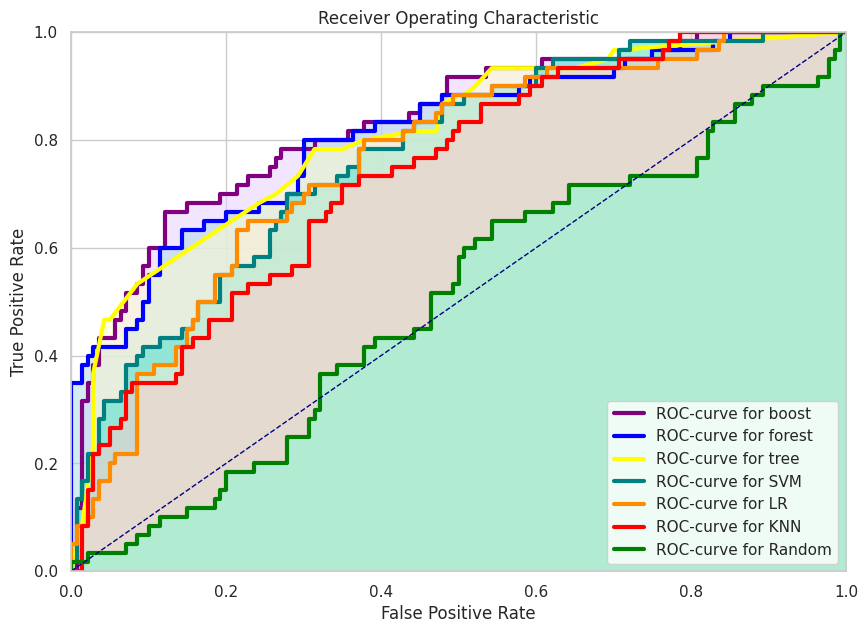

AUC for Gradient Boosting: 0.83
AUC for Random Forest: 0.81
AUC for Tree: 0.81
AUC for SVM: 0.77
AUC for Logistic Regression: 0.76
AUC for KNN: 0.74


In [611]:
predictions_knn = optimal_knn.predict_proba(test_feature_matrix_pca)
predictions_lr = optimal_lr.predict_proba(test_feature_matrix_pca)
predictions_svm = optimal_svm.predict_proba(test_feature_matrix_pca)
predictions_tree = tree.predict_proba(test_feature_matrix)
predictions_forest = forest.predict_proba(test_feature_matrix)
predictions_boosting = boost.predict_proba(test_feature_matrix)

plt.figure(figsize=(10, 7))


fpr_boost, tpr_boost, _ = roc_curve(test_labels, predictions_boosting[:, 1])
plt.plot(fpr_boost, tpr_boost,  color="#800080", lw=3, label="ROC-curve for boost")
plt.fill_between(fpr_boost, tpr_boost, color='#e6ccff', alpha=0.5)

fpr_forest, tpr_forest, _ = roc_curve(test_labels, predictions_forest[:, 1])
plt.plot(fpr_forest, tpr_forest, color="blue", lw=3, label="ROC-curve for forest")
plt.fill_between(fpr_forest, tpr_forest, color="#ADD8E6", alpha=0.5)

fpr_tree, tpr_tree, _ = roc_curve(test_labels, predictions_tree[:, 1])
plt.plot(fpr_tree, tpr_tree, color="yellow", lw=3, label="ROC-curve for tree")
plt.fill_between(fpr_tree, tpr_tree, color="#ffffcc", alpha=0.5)

fpr_svm, tpr_svm, _ = roc_curve(test_labels, predictions_svm[:, 1])
plt.plot(fpr_svm, tpr_svm, color="#008080", lw=3, label="ROC-curve for SVM")
plt.fill_between(fpr_svm, tpr_svm, color="#40E0D0", alpha=0.5)

fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_labels, predictions_lr[:, 1])
plt.plot(fpr_lr, tpr_lr, color="darkorange", lw=3, label="ROC-curve for LR")
plt.fill_between(fpr_lr, tpr_lr, color="papayawhip", alpha=0.5)

fpr_knn, tpr_knn, _ = roc_curve(test_labels, predictions_knn[:, 1])
plt.plot(fpr_knn, tpr_knn, color="red", lw=3, label="ROC-curve for KNN")
plt.fill_between(fpr_knn, tpr_knn, color='#ffcccc', alpha=0.5)

fpr_random, tpr_random, _ = roc_curve(test_labels, np.random.uniform(0, 1, test_labels.shape[0]))
plt.plot(fpr_random, tpr_random, color="green", lw=3, label="ROC-curve for Random")
plt.fill_between(fpr_random, tpr_random, color="aquamarine", alpha=0.5)


plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")

plt.legend()
plt.show()


auc_lr = roc_auc_score(test_labels, predictions_lr[:, 1])
auc_forest = roc_auc_score(test_labels, predictions_forest[:, 1])
auc_boost = roc_auc_score(test_labels, predictions_boosting[:, 1])
auc_svm = roc_auc_score(test_labels, predictions_svm[:, 1])
auc_knn = roc_auc_score(test_labels, predictions_knn[:, 1])
auc_tree = roc_auc_score(test_labels, predictions_tree[:, 1])


print(f"AUC for Gradient Boosting: {auc_boost:.2f}")
print(f"AUC for Random Forest: {auc_forest:.2f}")
print(f"AUC for Tree: {auc_tree:.2f}")
print(f"AUC for SVM: {auc_svm:.2f}")
print(f"AUC for Logistic Regression: {auc_lr:.2f}")
print(f"AUC for KNN: {auc_knn:.2f}")

Для нашего датасета самой лучшей моделью оказался градиентный бустинг!